<h1 align="center"> MNIST TensorFlow </h1>

A large part of this tutorial's purpose is to visualize weights using TensorFlow


In [32]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from struct import unpack
%matplotlib inline

Look into normalizing the data here. Maybe not instructional to have separate cell on it. 

In [33]:
def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.float32)  # Initialize numpy array
    
    # 10 because there are 10 classes; the numbers 1-10
    y = np.zeros(N, dtype=np.float32)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    y = (np.arange(10) == y[:,None]).astype(np.float32)
    images.close()
    labels.close()
    return (x, y)

def non_flattened_image(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

def flattened_image(image):
    plt.imshow(np.reshape(image, (784,1)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [34]:
train_img_path = 'train-images-idx3-ubyte' 
train_lbl_path = 'train-labels-idx1-ubyte' 
test_img_path = 't10k-images-idx3-ubyte' 
test_lbl_path = 't10k-labels-idx1-ubyte'

x_train, y_train = loadmnist(train_img_path, train_lbl_path)
#x_train, y_train = np.array(x_train).real.astype(np.float32, copy=False), np.array(y_train).real.astype(np.float32, copy=False) 
testing_data, testing_labels = loadmnist(test_img_path, test_lbl_path)
#testing_data, testing_labels = np.array(testing_data).real.astype(np.float32, copy=False), np.array(testing_labels).real.astype(np.float32, copy=False) 

In [35]:
x_train.shape

(60000, 784)

In [36]:
y_train.shape

(60000, 10)

In [37]:
y_train[3]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

<h1 align="left"> Making a Validation Test Set </h1>

training, validation, and test data set explanation

In [38]:
# The shape of the dataset is 60000 by 784. Each of the images is shaped flattened
x_train.shape

(60000, 784)

In [39]:
len(x_train)

60000

In [40]:
training_number = len(x_train) * 3/4
validation_number = len(x_train) * 1/4
total_number = training_number + validation_number
print ('training size: {}'.format(training_number))
print ('validation size: {}'.format(validation_number))
print ('training + validation size: {}'.format(training_number + validation_number))

training size: 45000
validation size: 15000
training + validation size: 60000


In [41]:
training_data, validation_data = x_train[0:training_number], x_train[training_number:total_number]

In [42]:
training_labels, validation_labels = y_train[0:training_number], y_train[training_number:total_number]

<h1 align="left"> Show example of the data </h1>

<h3 align="left"> How the Computer Sees the Data With Multinomial Logistic Regression </h3>

What is Logistic Regression? What is Multinomial Logistic Regression (Softmax Regression)?

This model doesn't account for the interrelationships between pixels as you can see below. 

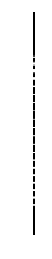

In [43]:
flattened_image(training_data[0,:])

<h3 align="left"> How we See the Data </h3>

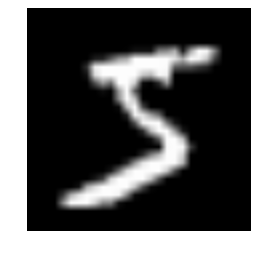

In [44]:
non_flattened_image(training_data[0,:])

<h1 align="left"> What is Logistic Regression? </h1>

research from tensorflow website

<h1 align="left"> What is Multinomial Logistic Regression (Softmax Regression)? </h1>

research from tensorflow website (maybe the image from the website) 

We're first going to train a multinomial logistic regression (sigmoid regression) using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [45]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000
image_size = 28
num_labels = 10

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(training_data[:train_subset, :])
    tf_train_labels = tf.constant(training_labels[:train_subset])
    tf_valid_dataset = tf.constant(validation_data)
    tf_test_dataset = tf.constant(testing_data)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  

    ## this next commented line is equalivalent to logits
    # tf.matmul(tf_train_dataset, weights) + biases  
    #pred = tf.nn.softmax(tf.matmul(tf_train_dataset, weights) + biases) # Softmax

    # Minimize error using cross entropy
    #cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
    # Gradient Descent
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    ### Testing 
    
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

V_accur_list = [] #verification accuracy list
step_list = [] # step number list
cost_list = []

In [47]:
num_steps = 1000

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 20 == 0):
            cost_list.append(l)
            step_list.append(step)
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
            predictions, y_train[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            valid_accuracy = accuracy(valid_prediction.eval(), validation_labels)
            V_accur_list.append(valid_accuracy)
            print('Validation accuracy: %.1f%%' % valid_accuracy)
    test_accuracy = accuracy(test_prediction.eval(), testing_labels)
    print('Test accuracy: %.1f%%' % test_accuracy)
    #This line below allows for taking the predictions to a pandas dataframe and eventually a heatmap/confusion matrix
    pred = test_prediction.eval()
    weights_matrix = weights.eval()

Initialized
Loss at step 0: 3355.098389
Training accuracy: 8.0%
Validation accuracy: 38.6%
Loss at step 20: 796.188354
Training accuracy: 81.7%
Validation accuracy: 82.1%
Loss at step 40: 337.566193
Training accuracy: 89.9%
Validation accuracy: 88.1%
Loss at step 60: 1818.627808
Training accuracy: 70.0%
Validation accuracy: 74.3%
Loss at step 80: 257.265137
Training accuracy: 91.0%
Validation accuracy: 88.7%
Loss at step 100: 364.349884
Training accuracy: 88.5%
Validation accuracy: 85.6%
Loss at step 120: 230.650208
Training accuracy: 91.9%
Validation accuracy: 89.2%
Loss at step 140: 340.510437
Training accuracy: 86.9%
Validation accuracy: 78.9%
Loss at step 160: 206.061447
Training accuracy: 92.4%
Validation accuracy: 89.5%
Loss at step 180: 896.965576
Training accuracy: 83.7%
Validation accuracy: 80.3%
Loss at step 200: 302.299438
Training accuracy: 90.1%
Validation accuracy: 89.1%
Loss at step 220: 208.521164
Training accuracy: 91.0%
Validation accuracy: 87.5%
Loss at step 240: 169

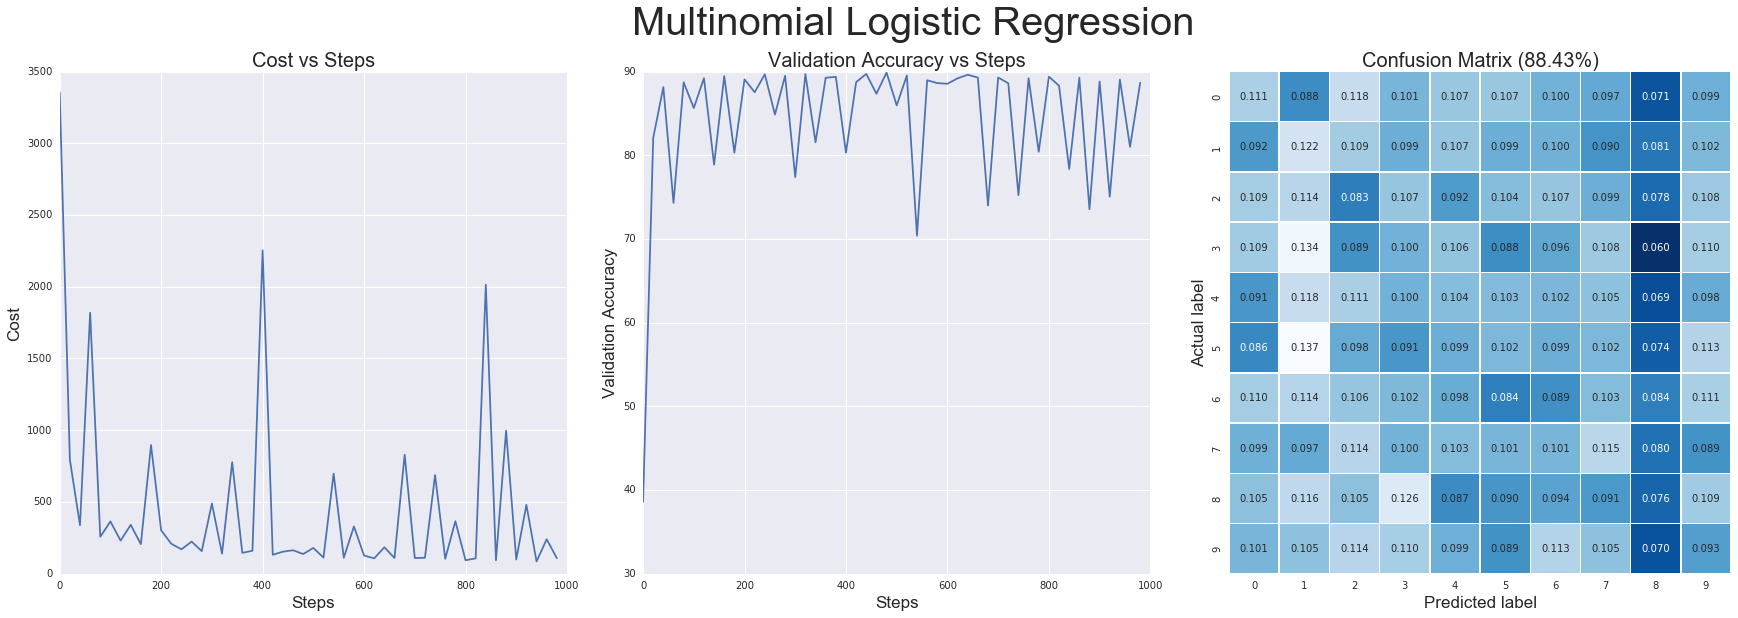

In [48]:
from sklearn import metrics
import pandas as pd
import seaborn as sns

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30,9));
fig.subplots_adjust(wspace=0.15, hspace=0) # Bringing subplots closer together. 
axes[0].plot(step_list, cost_list);
axes[0].set_figure
axes[0].set_title('Cost vs Steps', size = 20);
axes[0].set_xlabel('Steps', size = 17);
axes[0].set_ylabel('Cost', size = 17);
axes[1].plot(step_list, V_accur_list);
axes[1].set_title('Validation Accuracy vs Steps', size = 20);
axes[1].set_xlabel('Steps', size = 17);
axes[1].set_ylabel('Validation Accuracy', size = 17);

# predictions
predicted = [np.argmax(predictions[i,:], 0) for i in xrange(0,predictions.shape[0])]
#actual
t_labels = [np.where(testing_labels[i] == 1)[0][0] for i in xrange(0,predictions.shape[0])]

cm = metrics.confusion_matrix(t_labels, predicted)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
confusion_matrix = pd.DataFrame(data = cm_normalized)
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True,ax = axes[2], cmap = 'Blues_r', cbar = False);
axes[2].set_ylabel('Actual label', size = 17);
axes[2].set_xlabel('Predicted label', size = 17);
confusion_title = 'Confusion Matrix ({}%)'.format(test_accuracy)
axes[2].set_title(confusion_title, size = 20);
fig.suptitle('Multinomial Logistic Regression', y=1,x = .52, size = 40);

Visualizing Weights

This is supposed to be the weights of the three


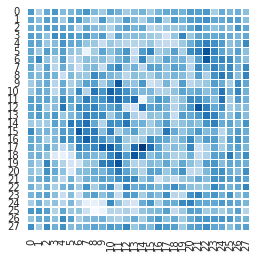

In [80]:
zero_visual = weights_matrix[:,3].reshape(28,28)
confusion_matrix = pd.DataFrame(data = zero_visual)
sns.heatmap(confusion_matrix, linewidths=.5, square = True, cmap = 'Blues_r', cbar = False);
print('This is supposed to be the weights of the three')

<h1 align="left"> 1 Layer Neural Network </h1>

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [88]:
V_accur_list, step_list, cost_list = [], [], []

In [89]:
# Setting up the Computation graph always comes first

batch_size = 128
n_hidden_nodes = 1024
image_size = 28

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be 
    # fed at runtime with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(validation_data)
    tf_test_dataset = tf.constant(testing_data)
    
    # Variables.
    weights_01 = tf.Variable(
    tf.truncated_normal([image_size * image_size, n_hidden_nodes]))
    weights_12 = tf.Variable(tf.truncated_normal([n_hidden_nodes, num_labels]))
    biases_01 = tf.Variable(tf.zeros([n_hidden_nodes]))
    biases_12 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    z_01= tf.matmul(tf_train_dataset, weights_01) + biases_01
    h1 = tf.nn.relu(z_01)
    z_12 = tf.matmul(h1, weights_12) + biases_12
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(z_12, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(z_12)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_01) + biases_01), weights_12) + biases_12)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_01) + biases_01), weights_12) + biases_12) 

In [91]:
num_steps = 1000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = x_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            cost_list.append(l)
            step_list.append(step)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            valid_accuracy = accuracy(valid_prediction.eval(), validation_labels)
            V_accur_list.append(valid_accuracy)
            print("Validation accuracy: %.1f%%" % valid_accuracy)
    test_accuracy = accuracy(test_prediction.eval(), testing_labels)
    print('Test accuracy: %.1f%%' % test_accuracy)
    #This line below allows for taking the predictions to a pandas dataframe and eventually a heatmap/confusion matrix
    pred = test_prediction.eval()

Initialized
Minibatch loss at step 0: 71497.054688
Minibatch accuracy: 7.8%
Validation accuracy: 10.0%
Minibatch loss at step 100: 1201.343384
Minibatch accuracy: 13.3%
Validation accuracy: 11.7%
Minibatch loss at step 200: 2.302629
Minibatch accuracy: 10.2%
Validation accuracy: 11.4%
Minibatch loss at step 300: 2.264886
Minibatch accuracy: 19.5%
Validation accuracy: 10.9%
Minibatch loss at step 400: 2.303076
Minibatch accuracy: 7.0%
Validation accuracy: 10.9%
Minibatch loss at step 500: 2.297338
Minibatch accuracy: 12.5%
Validation accuracy: 11.5%
Minibatch loss at step 600: 5.509095
Minibatch accuracy: 17.2%
Validation accuracy: 10.9%
Minibatch loss at step 700: 2.305910
Minibatch accuracy: 8.6%
Validation accuracy: 10.9%
Minibatch loss at step 800: 2.301982
Minibatch accuracy: 11.7%
Validation accuracy: 10.9%
Minibatch loss at step 900: 2.286079
Minibatch accuracy: 10.2%
Validation accuracy: 10.9%
Test accuracy: 11.1%


In [92]:
testing_labels

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)